Current UTC time: 2024-05-23 02:54:00
Current UTC time: 2024-05-23 02:54:05
61
61
closest_distance: 8.06225774829855
Closest white pixel coordinates: (x=53, y=62)
Closest white pixel azimuth: 82.8749836510982, elevation: 79.42654721534616, Zenith: 10.573452784653838


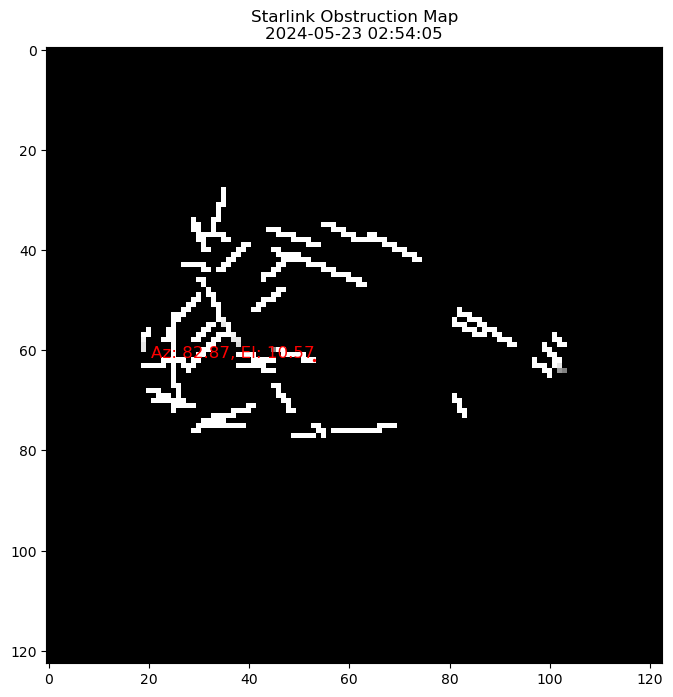

In [355]:
import sys
import os

# Add the path to starlink-grpc-tools-main to the system path
sys.path.append(os.path.abspath('E:\SatInView/starlink-grpc-tools-main'))
import math
import starlink_grpc
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import time

def calculate_azimuth_elevation(image_width, image_height):
    # Ensure the image is square
    assert image_width == image_height, "Image must be square"
    
    center_x = image_width // 2
    center_y = image_height // 2
    
    azimuth_elevation_map = []

    for y in range(image_height):
        row = []
        for x in range(image_width):
            # Convert pixel (x, y) to Cartesian coordinates with the center as (0, 0)
            dx = x - center_x
            dy = center_y - y  # Adjust dy to invert y-axis

            # Calculate azimuth
            azimuth = (math.degrees(math.atan2(-dx, -dy)) + 360) % 360
            
            # Calculate elevation
            distance_from_center = math.sqrt(dx**2 + dy**2)
            max_distance = center_x  # max distance in pixels
            elevation = 10 + 80 * (1 - (distance_from_center / max_distance))  # Minimum elevation is 0 degrees

            if distance_from_center > max_distance:
                # Pixels outside the circle represent "no data"
                row.append((None, None))
            else:
                row.append((azimuth, elevation))
        
        azimuth_elevation_map.append(row)
    
    return azimuth_elevation_map

def find_closest_white_pixel(snr_data, azimuth_elevation_map):
    center_x = len(snr_data[0]) // 2
    center_y = len(snr_data) // 2
    closest_distance = float('inf')
    closest_azimuth = None
    closest_elevation = None
    closest_x = None
    closest_y = None

    for y in range(len(snr_data)):
        for x in range(len(snr_data[y])):
            if snr_data[y][x] == 1:  # Check if the pixel is white
                dx = x - center_x
                dy = y - center_y  # Do not invert dy for distance calculation
                distance = math.sqrt(dx**2 + dy**2)

                if distance < closest_distance:
                    closest_distance = distance
                    closest_azimuth, closest_elevation = azimuth_elevation_map[y][x]
                    closest_x = x
                    closest_y = y

    return closest_azimuth, closest_elevation, closest_x, closest_y,closest_distance


# Assuming this function gets snr_data from the dish
context = starlink_grpc.ChannelContext(target="192.168.100.1:9200")  # Example target
try:
    # starlink_grpc.reset_obstruction_map(context)
    current_utc_time = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    print(f"Current UTC time: {current_utc_time}")
    time.sleep(5)
    snr_data = starlink_grpc.obstruction_map(context)
    current_utc_time = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")
    print(f"Current UTC time: {current_utc_time}")
except starlink_grpc.GrpcError as e:
    print("Failed getting obstruction map data:", str(e))
    # return

if not snr_data or not snr_data[0]:
    print("Invalid SNR map data: Zero-length")
    # return

image_width = len(snr_data[0])
image_height = len(snr_data)
print(len(snr_data[0]) // 2)
print(len(snr_data) // 2)
azimuth_elevation_map = calculate_azimuth_elevation(image_width, image_height)
closest_azimuth, closest_elevation, closest_x, closest_y,closest_distance = find_closest_white_pixel(snr_data, azimuth_elevation_map)

current_utc_time = datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S")

if closest_azimuth is not None and closest_elevation is not None:
    print(f"closest_distance: {closest_distance}")
    print(f"Closest white pixel coordinates: (x={closest_x}, y={closest_y})")
    print(f"Closest white pixel azimuth: {closest_azimuth}, elevation: {closest_elevation}, Zenith: {90-closest_elevation}")
else:
    print(f"Current UTC time: {current_utc_time}")
    print("No white pixel found.")

# Plotting the image
plt.figure(figsize=(8, 8))
plt.imshow(snr_data, cmap='gray', origin='upper')  # Adjust origin to 'upper' to correct orientation

if closest_x is not None and closest_y is not None:
    plt.scatter([closest_x], [closest_y], color='red', marker='o', s=2)
    plt.text(closest_x, closest_y, f'Az: {closest_azimuth:.2f}, El: {90-closest_elevation:.2f}', 
             color='red', fontsize=12, ha='right', va='bottom')

plt.title(f'Starlink Obstruction Map\n{current_utc_time}')
# plt.xlabel('Azimuth (degrees)')
# plt.ylabel('Elevation (degrees)')
plt.show()



Loaded 6017 satellites
STARLINK-1047 catalog #44752 epoch 2024-05-21 16:30:53 UTC at Azimuth: 142.88821455314599°, Altitude: 47.06642167731763°, Distance: 727.8485328537747 km
STARLINK-1156 catalog #45054 epoch 2024-05-22 19:51:00 UTC at Azimuth: 211.09925523931227°, Altitude: 30.296600877324593°, Distance: 987.2123475715955 km
STARLINK-1161 catalog #45068 epoch 2024-05-22 19:46:57 UTC at Azimuth: 290.9583188341645°, Altitude: 47.68905277021225°, Distance: 723.4056069381887 km
STARLINK-1177 catalog #45078 epoch 2024-05-22 19:48:21 UTC at Azimuth: 268.7209818229183°, Altitude: 24.006836313573736°, Distance: 1157.8964001456804 km
STARLINK-1137 catalog #45092 epoch 2024-05-22 13:18:12 UTC at Azimuth: 59.74552440520149°, Altitude: 20.88450445924682°, Distance: 1265.7718661303966 km
STARLINK-1479 catalog #45740 epoch 2024-05-22 19:41:42 UTC at Azimuth: 331.9915293680785°, Altitude: 38.720445033454396°, Distance: 834.3165183426075 km
STARLINK-1494 catalog #45760 epoch 2024-05-21 16:34:52 UTC

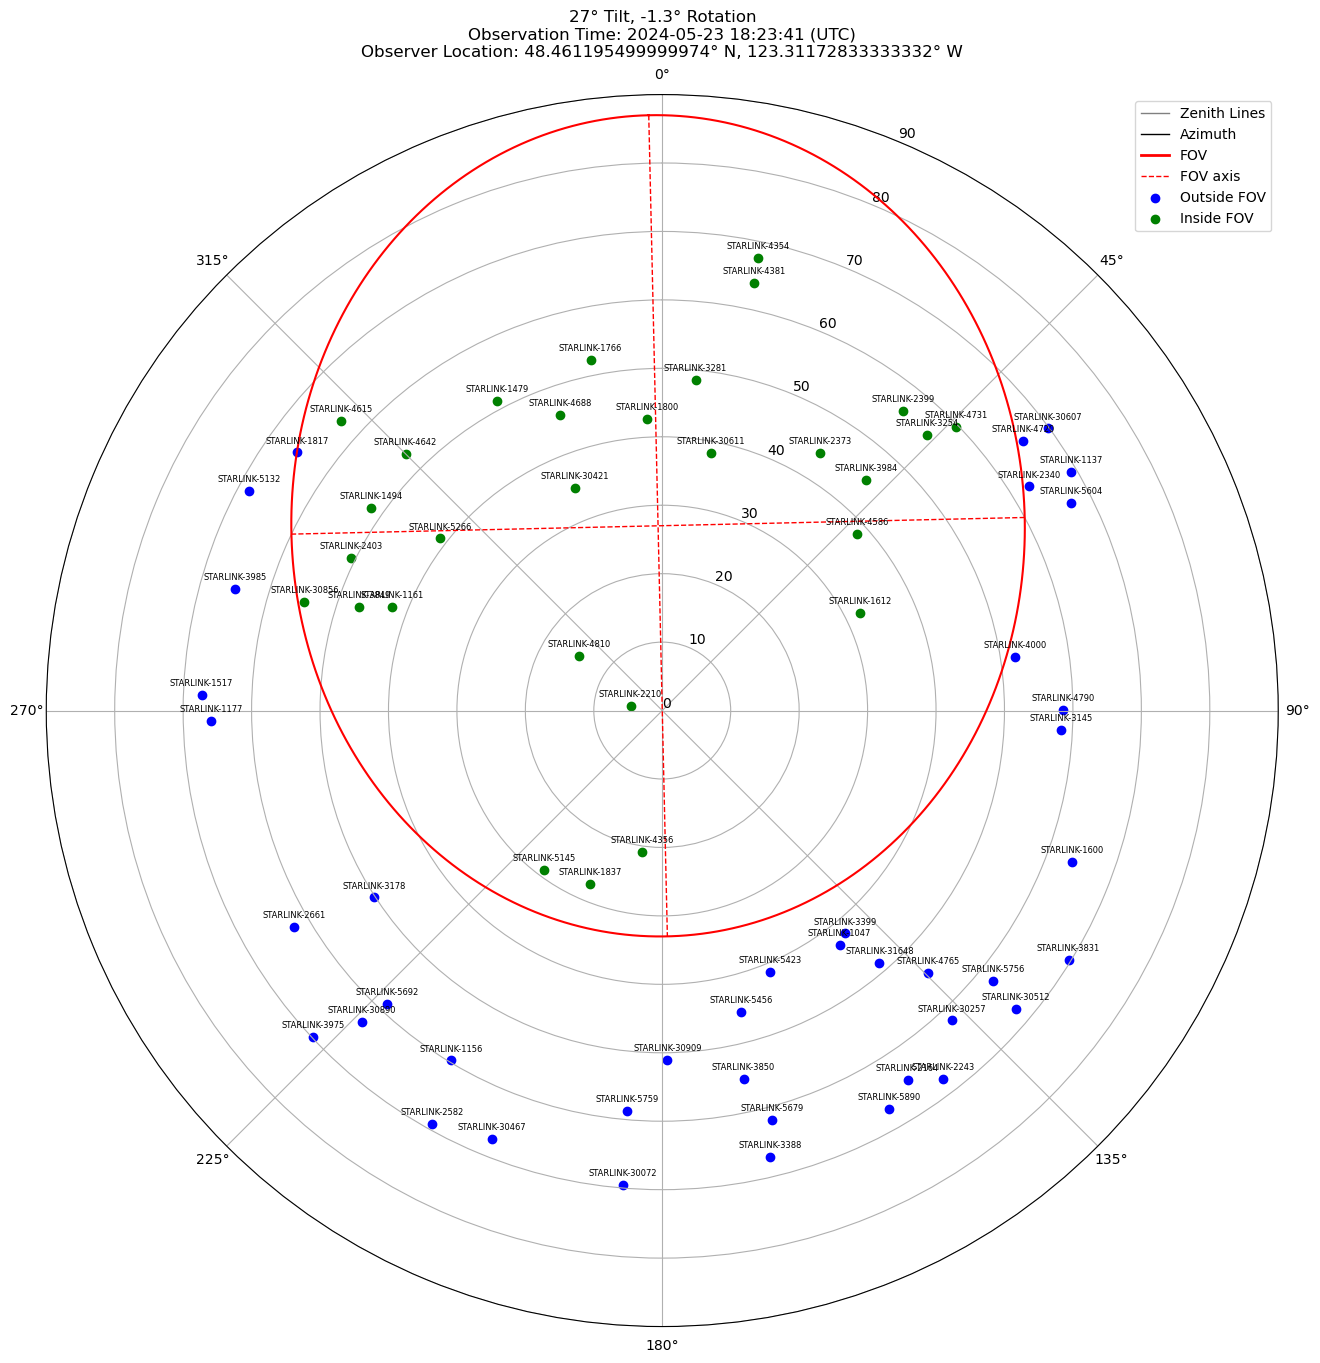

Satellites inside the FOV: ['STARLINK-1161', 'STARLINK-1479', 'STARLINK-1494', 'STARLINK-1612', 'STARLINK-1766', 'STARLINK-1800', 'STARLINK-1837', 'STARLINK-2210', 'STARLINK-2373', 'STARLINK-2399', 'STARLINK-2403', 'STARLINK-3281', 'STARLINK-3254', 'STARLINK-3849', 'STARLINK-3984', 'STARLINK-4381', 'STARLINK-4354', 'STARLINK-4356', 'STARLINK-4615', 'STARLINK-4586', 'STARLINK-4731', 'STARLINK-4688', 'STARLINK-4642', 'STARLINK-4810', 'STARLINK-5145', 'STARLINK-5266', 'STARLINK-30421', 'STARLINK-30611', 'STARLINK-30856']


In [8]:
from skyfield.api import load, wgs84, Topos
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
import math

def load_data():
    stations_url = 'https://celestrak.org/NORAD/elements/gp.php?GROUP=starlink&FORMAT=tle'
    satellites = load.tle_file(stations_url)
    print('Loaded', len(satellites), 'satellites')
    return satellites

def set_observation_time_now(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.now()- timedelta(seconds=1)
def set_observation_time(year, month, day, hour, minute, second):
    ts = load.timescale()
    return ts.utc(year, month, day, hour, minute, second)

def calculate_satellite_positions(satellites, observer_location, observation_time):
    locations = []
    sats = []
    min_elevation = 20
    for satellite in satellites:
        difference = satellite - observer_location
        topocentric = difference.at(observation_time)
        alt, az, distance = topocentric.altaz()
        if alt.degrees > min_elevation:
            loc = [(90 - alt.degrees, np.radians(az.degrees))]
            locations.append(loc)
            sats.append(satellite)
            print(f"{satellite} at Azimuth: {az.degrees}°, Altitude: {alt.degrees}°, Distance: {distance.km} km")
    return locations, sats

def rotate_points(x, y, angle):
    x_rot = x * np.cos(angle) - y * np.sin(angle)
    y_rot = x * np.sin(angle) + y * np.cos(angle)
    return x_rot, y_rot

def draw_fov(tilt_deg, rotation_deg, locations, sats, observation_time, observer_location):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(16, 16))

    # Plot settings
    ax.set_ylim(0, 90)
    ax.set_yticks(np.arange(0, 91, 10))
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.grid(True)

    zenith_legend = plt.Line2D([0], [0], color='gray', linestyle='-', linewidth=1, label='Zenith Lines')
    azimuth_legend = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=1, label='Azimuth')
    FOV = plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='FOV')
    Axis = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=1, label='FOV axis')
    ax.add_artist(zenith_legend)
    ax.add_artist(azimuth_legend)
    ax.add_artist(FOV)
    ax.add_artist(Axis)

    # FOV ellipse
    base_radius = 60
    center_shift = tilt_deg
    x_radius = base_radius
    y_radius = math.sqrt(base_radius**2 - tilt_deg**2)

    theta = np.linspace(0, 2 * np.pi, 300)
    x = x_radius * np.cos(theta) + center_shift
    y = y_radius * np.sin(theta)
    r = np.sqrt(x**2 + y**2)
    angles = np.arctan2(y, x) + np.deg2rad(rotation_deg)
    ax.plot(angles, r, 'r')

    # Plot major and minor axes
    major_axis_x = np.array([center_shift + x_radius, center_shift - x_radius])
    major_axis_y = np.array([0, 0])
    minor_axis_x = np.array([center_shift, center_shift])
    minor_axis_y = np.array([y_radius, -y_radius])
    major_axis_x_rot, major_axis_y_rot = rotate_points(major_axis_x, major_axis_y, np.deg2rad(rotation_deg))
    minor_axis_x_rot, minor_axis_y_rot = rotate_points(minor_axis_x, minor_axis_y, np.deg2rad(rotation_deg))
    ax.plot(np.arctan2(major_axis_y_rot, major_axis_x_rot), np.sqrt(major_axis_x_rot**2 + major_axis_y_rot**2), 'red', linestyle='--', linewidth=1)
    ax.plot(np.arctan2(minor_axis_y_rot, minor_axis_x_rot), np.sqrt(minor_axis_x_rot**2 + minor_axis_y_rot**2), 'red', linestyle='--', linewidth=1)

    inside_fov = []

    # Plot satellites
    for loc, sat in zip(locations, sats):
        loc = np.array(loc)
        r = loc[:, 0]
        angle = loc[:, 1]
        inside = False
        for r_i, angle_i in zip(r, angle):
            x_point = r_i * np.cos(angle_i)
            y_point = r_i * np.sin(angle_i)
            x_point_rot, y_point_rot = rotate_points(x_point, y_point, -np.deg2rad(rotation_deg))
            x_point_rot -= center_shift
            if (x_point_rot**2 / x_radius**2) + (y_point_rot**2 / y_radius**2) <= 1:
                inside = True
                break
        if inside:
            ax.scatter(angle, r, color="g", label="Inside FOV")
            inside_fov.append(sat.name)
        else:
            ax.scatter(angle, r, color="b", label="Outside FOV")
        ax.annotate(sat.name, xy=(angle, r), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontsize=6, bbox=dict(boxstyle='round,pad=0.5', edgecolor='none', facecolor='none', alpha=0.6))

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    # Format the observation time
    observation_time_str = observation_time.utc_strftime('%Y-%m-%d %H:%M:%S (UTC)')
    latitude_str = f"{abs(observer_location.latitude.degrees)}° {'N' if observer_location.latitude.degrees >= 0 else 'S'}"
    longitude_str = f"{abs(observer_location.longitude.degrees)}° {'E' if observer_location.longitude.degrees >= 0 else 'W'}"
    observer_location_str = f"{latitude_str}, {longitude_str}"
    ax.set_title(f'{tilt_deg}° Tilt, {rotation_deg}° Rotation\nObservation Time: {observation_time_str}\nObserver Location: {observer_location_str}', va='bottom')
    
    # ax.scatter(np.deg2rad(closest_azimuth), 90-closest_elevation, color='red', marker='o', s=150)
    plt.show()
    print("Satellites inside the FOV:", inside_fov)
    # print("what", closest_azimuth)

if __name__ == "__main__":
    satellites = load_data()
    initial_time = set_observation_time_now(2024, 5, 23, 2, 23, 12 )
    observer_location = wgs84.latlon(latitude_degrees=48.461195499999974, longitude_degrees=-123.31172833333332, elevation_m=73)
    locations, sats = calculate_satellite_positions(satellites, observer_location, initial_time)
    draw_fov(27,-1.3, locations, sats, initial_time, observer_location)
    # draw_fov(10, 45, locations, sats, initial_time, observer_location)
    # draw_fov(20, 90, locations, sats, initial_time, observer_location)
    # draw_fov(30, 315, locations, sats, initial_time, observer_location)


### 